In [631]:
import os
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import d2l.torch as d2l
import visdom
import torch.nn.functional as F
import glob 
from Bio import SeqIO
from sklearn.metrics import classification_report, roc_curve, auc
from torch.utils.data import DataLoader
import pandas as pd
from transformers import BertModel, BertTokenizer 
import re

In [632]:
os.chdir("grs34806-deep-learning-project-data")
global DEVICE

if torch.cuda.is_available():
    DEVICE = "cuda"

else:
    DEVICE = "cpu"



FileNotFoundError: [Errno 2] No such file or directory: 'grs34806-deep-learning-project-data'

In [633]:
plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = 'white'

In [634]:
# Data class for the BMF data


class Data:
    seed = 13

    def __init__(self, seqPath, posPath):
        self.seqPath = seqPath
        self.posPath = posPath
        self.seq = None
        self.lab = None
        self.train = None
        self.test = None
        self.length = None
        self.init_data()

    def init_data(self):
        self.read()
        self.split()
        self.length = max(list(map(len, self.seq)))

    def __repr__(self):
        return self.__class__.__name__ + " instance"

    def __len__(self):
        return self.length

    def read(self):
        """
        Reads the data from the given sequence and position files.

        Parameters:
        seqPath (str): The path to the sequence file.
        posPath (str): The path to the position file.

        Returns:
        A tuple containing the sequences and labels.
        """

        seq = []
        lab = []
        encode = {}

        with open(self.seqPath, "r") as f:
            for line in f:
                line = line.strip().split("\t")
                seq.append(line[1])
                lab.append(line[0])

        with open(self.posPath, "r") as f:
            for line in f:
                line = line.strip()
                encode[line] = [1, 0]

        # TODO: make this compatible with more classes
        lab = [encode.get(x, [0, 1]) for x in lab]
        self.seq = seq
        self.lab = lab

    def split(self):
        """
        Splits the data into training and test sets.

        Parameters:
        sequences (list): The sequences.
        labels (list): The labels.

        Returns:
        A tuple containing the training and test sets.
        """

        train_sequences, test_sequences, train_labels, test_labels = train_test_split(
            self.seq, self.lab, test_size=0.2, random_state=Data.seed
        )
        self.train = (train_sequences, train_labels)
        self.test =  (test_sequences, test_labels)

    def load_data(self, batch_size, num_steps, eval=False):
        """
        Load the data into a data iterator with the specified batch size and number of time steps.

        Parameters:
        batch_size (int): The batch size.
        num_steps (int): The number of time steps.

        Returns:
        A data iterator that returns batches of data with shape (batch_size, num_steps).
        """

        mapaa2num = {aa: i for (i, aa) in enumerate(list("ACDEFGHIKLMNPQRSTVWY"))}
        seq, lab = self.test if eval else self.train
        seq = self.tokenize(seq, mapaa2num)
        seq_array = self.build_seq_array(seq, num_steps)
        one_hot_array = nn.functional.one_hot(seq_array, -1).float()
        data_arrays = (one_hot_array, torch.tensor(lab, dtype=torch.float32))
        data_iter = d2l.load_array(data_arrays, batch_size)
        return data_iter

    def tokenize(self, dat, map2num, non_aa_num=20):
        """
        This function takes a list of amino acid sequences and a mapping from amino acids to integers and returns a list of tokenized sequences. The tokens are integers representing the amino acids, with unknown amino acids represented by a special "padding" token.

        Parameters:
        dat (list): A list of amino acid sequences.
        map2num (dict): A mapping from amino acids to integers.
        non_aa_num (int, optional): The integer value used to represent unknown amino acids. The default value is 20.

        Returns:
        list: A list of tokenized sequences.
        """

        seq = []
        for i in dat:
            seq.append([map2num.get(j, non_aa_num) for j in list(i)])
        return seq

    def build_seq_array(self, lines, num_steps, non_aa_num=20):
        """
        Build a sequence array from a list of lines.

        Parameters:
        lines (list): A list of lines.
        num_steps (int): The number of time steps.

        Returns:
        A sequence array.
        """

        array = torch.tensor(
            [self.truncate_pad(l, num_steps, non_aa_num) for l in lines]
        )
        return array

    def truncate_pad(self, line, num_steps, padding_token):
        """
        Truncates or pads a list of integers to a specified length.

        Parameters:
        line (List[int]): The list of integers to be truncated or padded.
        num_steps (int): The desired length of the truncated or padded list.
        padding_token (int): The integer value used for padding.

        Returns:
        A list of integers of length num_steps, truncated or padded as needed.

        """

        if len(line) > num_steps:
            return line[:num_steps]  # Truncate
        return line + [padding_token] * (num_steps - len(line))


In [635]:
data= Data(seqPath="len100_200_n1000.seq", posPath="len100_200_n1000.pos")

## models

In [636]:
class SimModel(nn.Module):
    def __init__(self, dropout=0.0, verbose=False, num_classes=2):
        super().__init__()
        self.verbose = verbose 
        self.num_classes = num_classes
        self.block1 = nn.Sequential(
            nn.LazyConv1d(64, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(64, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.MaxPool1d(2),
        )

        self.fc = nn.Sequential(
            nn.LazyLinear(256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        verbose = False
        x = self.block1(x)

        if verbose:
            print(f"shape after block 1: {x.shape}")

        x = x.flatten(start_dim=1)
        if verbose:
            print(f"shape after flattening :{x.shape}")

        x = self.fc(x)

        if verbose:
            print(f"shape after fc1 :{x.shape}")
            
        if self.num_classes == 2:
            x = F.softmax(x, dim = 1)
        else:
            x = F.sigmoid(x)

        return x


In [637]:
# from Dive into DeepLearning: resnet residual block class
# this should be able to move to CUDA while keeping numbers of code line low 

class Residual(nn.Module):  
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()

        self.conv1 = nn.LazyConv1d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv1d(num_channels, kernel_size=3, padding=1)

        if use_1x1conv:
            self.conv3 = nn.LazyConv1d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None

        self.bn1 = nn.LazyBatchNorm1d()
        self.bn2 = nn.LazyBatchNorm1d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)

        Y += X
        return F.relu(Y)

In [638]:
# average length sequence amino acids motifs is 20 on average hence we choose a kernel size of 27 in the initial layer. With padding = "same"

class ProtModel(nn.Module):
    def __init__(self, dropout=0.0, verbose=False, num_classes=2):
        super().__init__()
        self.num_classes = num_classes
        self.verbose = verbose
        self.init = nn.Sequential(
            nn.LazyConv1d(64, kernel_size=27, padding="same", stride=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        self.residual1 = Residual(128, use_1x1conv=True, strides=2)
        self.residual2 = Residual(512, use_1x1conv=True, strides=2)
    
        
        self.fc = nn.Sequential(
            nn.LazyLinear(256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.LazyLinear(256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.LazyLinear(num_classes),
        )

    def forward(self, x):
        verbose = self.verbose
        x = self.init(x)
        if verbose:
            print(f"shape after init layer: {x.shape}")
        
        x = self.residual1(x)
        if verbose:
            print(f"shape after residual layer 1: {x.shape}")

        x = self.residual2(x)
        if verbose:
            print(f"shape after residual layer 2: {x.shape}")

        x = x.flatten(start_dim=1)
        if verbose:
            print(f"shape after flattening :{x.shape}")

        x = self.fc(x)
        if verbose:
            print(f"shape after fc1 :{x.shape}")
        
        if self.num_classes == 2:
            x = F.softmax(x, dim=1)
        else:
            x = F.sigmoid(x)


        return x


## visdom plotting class

In [639]:
# this code is from https://github.com/noagarcia/visdom-tutorial


class VisdomLinePlotter(object):
    def __init__(self, env_name):
        self.viz = visdom.Visdom()
        self.env = env_name
        self.plots = {}

    def plot(self, var_name, split_name, title_name, x, y):
        if var_name not in self.plots:
            self.plots[var_name] = self.viz.line(
                X=np.array([x, x]),
                Y=np.array([y, y]),
                env=self.env,
                opts=dict(
                    legend=[split_name],
                    title=title_name,
                    xlabel="Epochs",
                    ylabel=var_name,

                ),
            )
        else:
            self.viz.line(
                X=np.array([x]),
                Y=np.array([y]),
                env=self.env,
                win=self.plots[var_name],
                name=split_name,
                update="append",
            )


global plotter


## train loop

In [640]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

def f1_score(y, y_hat, threshold=0.5):
    y = y.cpu().numpy()
    y_hat = (y_hat > threshold).detach().cpu().numpy()
    report = classification_report(y, y_hat, output_dict=True, target_names=data.class_labels)
    return report["micro avg"]["f1-score"], report["macro avg"]["f1-score"]

def train_model(
    model, data, criterion, optimizer, epochs=10, batch_size=10, input_length=200, num_classes=2
):

    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(epochs):

        for X, y in data.load_data(batch_size, input_length):
            X, y = torch.permute(X, (0, 2, 1)).to(DEVICE), y.float().to(DEVICE)

            y_hat = model(X.float())
            loss = criterion(y_hat, y)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        plotter.plot("loss", "train", "loss", epoch, loss.item())
        train_losses.append(loss.item())
        
        if num_classes < 3:
            score = (y_hat.argmax(dim=1) == y.argmax(1)).float().mean().item()
            plotter.plot("accuracy", "train", "training accuracy", epoch, score)
        else:
            score = f1_score(y, y_hat)
            plotter.plot("f1 score (micro)", "train", "micro avg f1 score", epoch, score[0])
            plotter.plot("f1 score (macro)", "train", "macro avg f1 score", epoch, score[1])

        train_accs.append(score)

        with torch.inference_mode():
            for X, y in data.load_data(batch_size, input_length, eval=True):
                X, y = torch.permute(X, (0, 2, 1)).to(DEVICE), y.float().to(DEVICE)

                y_hat = model(X.float())
                loss = criterion(y_hat, y)

        plotter.plot("loss", "test", "loss", epoch, loss.item())
        test_losses.append(loss.item())

        if num_classes < 3:
            score = (y_hat.argmax(dim=1) == y.argmax(1)).float().mean().item()
            plotter.plot("accuracy", "test", "test accuracy", epoch, score)
        else: 
            score = f1_score(y, y_hat)
            plotter.plot("f1 score (micro)", "test", "micro avg f1 score", epoch, score[0])
            plotter.plot("f1 score (macro)", "test", "macro avg f1 score", epoch, score[1])
        
        test_accs.append(score)
        
        train_metric_string = "trainig accuracy:" if num_classes < 3 else "training hamming loss:"
        test_metric_string = "test accuracy:" if num_classes < 3 else "test hamming loss:"

        string = f"epoch: {epoch}\ttraining loss: {train_losses[-1]:.2f}\ttest loss{test_losses[-1]:.2f}"

        print(
            string
        )

    return model, train_losses, train_accs, test_losses, test_accs


## hyperparameter testing

In [641]:
learning_rates

[0.1, 0.01, 0.001, 0.0001, 1e-05]

### learning rate

In [643]:
# hyperparameter testing for learning rate
crit = nn.CrossEntropyLoss()
scores = {"fprs": [], "tprs": [], "aucs": []}

learning_rates = [0.1/10**x for x in range(0, 5)]
for learningRate in learning_rates:
    model = SimModel().to(DEVICE)
    name = "LR_" + str(learningRate)
    plotter = VisdomLinePlotter(name)
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    trained_model, trainloss, trainacc, testloss, testacc = train_model(model, data, crit, optimizer, input_length=512, epochs=100, batch_size=25, num_classes=2)
    
    # predict all the test data 
    X, y = next(iter(data.load_data(200, 512, eval=True)))
    X, y = torch.permute(X, (0, 2, 1)).to(DEVICE), y.float().to(DEVICE)
    pred = trained_model(X)
    pred, y = pred.argmax(dim=1), y.argmax(dim=1)
    fpr, tpr, _ = roc_curve(y.cpu().numpy(), pred.cpu().detach().numpy())
    roc_auc = auc(fpr, tpr)
    
    scores["fprs"].append(fpr)
    scores["tprs"].append(tpr)
    scores["aucs"].append(roc_auc)

    
    


Setting up a new session...


epoch: 0	training loss: 0.67	test loss0.99
epoch: 1	training loss: 0.79	test loss0.95
epoch: 2	training loss: 0.79	test loss0.87
epoch: 3	training loss: 0.79	test loss0.71
epoch: 4	training loss: 0.71	test loss0.76


KeyboardInterrupt: 

In [644]:
data = Data(
    "len200_500_n1000.seq",
    "len200_500_n1000.pos",
)


ValueError: x and y must have same first dimension, but have shapes (5,) and (0,)

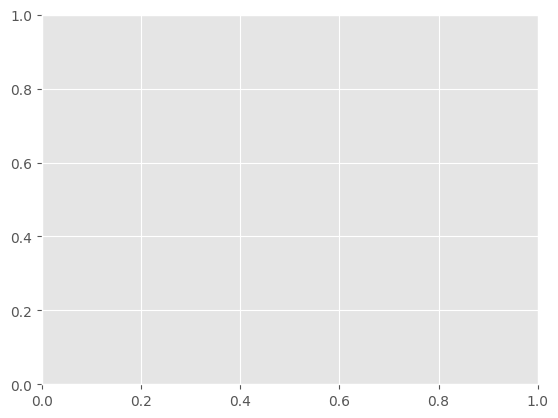

In [645]:
plt.plot(learning_rates, scores["aucs"], marker="o", mfc="r")
plt.xlabel("learning rate")
plt.ylabel("AUC")
plt.xscale("log")
plt.savefig("../SimModel_aucs.png", dpi = 350, facecolor = "white")

### dropout 

In [281]:
np.linspace(0, 1, 21)[:-2]

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 ])

In [283]:
# hyperparameter testing for learning rate
crit = nn.CrossEntropyLoss()
scores = {"fprs": [], "tprs": [], "aucs": []}

dropouts = np.linspace(0, 1, 21)[:-2]
for dropout in dropouts:
    model = SimModel(dropout=dropout).to(DEVICE)
    name = "dropout_" + str(dropout)
    plotter = VisdomLinePlotter(name)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    trained_model, trainloss, trainacc, testloss, testacc = train_model(model, data, crit, optimizer, input_length=512, epochs=100, batch_size=25, num_classes=2)
    
    # predict all the test data 
    X, y = next(iter(data.load_data(200, 512, eval=True)))
    X, y = torch.permute(X, (0, 2, 1)).to(DEVICE), y.float().to(DEVICE)
    pred = trained_model(X)
    pred, y = pred.argmax(dim=1), y.argmax(dim=1)
    fpr, tpr, _ = roc_curve(y.cpu().numpy(), pred.cpu().detach().numpy())
    roc_auc = auc(fpr, tpr)
    
    scores["fprs"].append(fpr)
    scores["tprs"].append(tpr)
    scores["aucs"].append(roc_auc)


    
    


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Setting up a new session...


epoch: 0	training loss: 0.74	test loss0.67
epoch: 1	training loss: 0.86	test loss0.66
epoch: 2	training loss: 0.60	test loss0.73
epoch: 3	training loss: 0.46	test loss0.77
epoch: 4	training loss: 0.47	test loss0.73
epoch: 5	training loss: 0.39	test loss0.70
epoch: 6	training loss: 0.44	test loss0.69
epoch: 7	training loss: 0.43	test loss0.63
epoch: 8	training loss: 0.43	test loss0.71
epoch: 9	training loss: 0.32	test loss0.62
epoch: 10	training loss: 0.31	test loss0.69
epoch: 11	training loss: 0.33	test loss0.65
epoch: 12	training loss: 0.31	test loss0.74
epoch: 13	training loss: 0.31	test loss0.49
epoch: 14	training loss: 0.31	test loss0.60
epoch: 15	training loss: 0.35	test loss0.54
epoch: 16	training loss: 0.35	test loss0.54
epoch: 17	training loss: 0.39	test loss0.69
epoch: 18	training loss: 0.34	test loss0.46
epoch: 19	training loss: 0.39	test loss0.55
epoch: 20	training loss: 0.40	test loss0.74
epoch: 21	training loss: 0.31	test loss0.53
epoch: 22	training loss: 0.31	test loss0.3

/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Setting up a new session...


epoch: 0	training loss: 0.75	test loss0.75
epoch: 1	training loss: 0.67	test loss0.83
epoch: 2	training loss: 0.61	test loss0.62
epoch: 3	training loss: 0.55	test loss0.79
epoch: 4	training loss: 0.56	test loss0.62
epoch: 5	training loss: 0.40	test loss0.60
epoch: 6	training loss: 0.34	test loss0.63
epoch: 7	training loss: 0.43	test loss0.59
epoch: 8	training loss: 0.32	test loss0.64
epoch: 9	training loss: 0.35	test loss0.55
epoch: 10	training loss: 0.35	test loss0.62
epoch: 11	training loss: 0.43	test loss0.55
epoch: 12	training loss: 0.35	test loss0.52
epoch: 13	training loss: 0.42	test loss0.63
epoch: 14	training loss: 0.32	test loss0.67
epoch: 15	training loss: 0.35	test loss0.54
epoch: 16	training loss: 0.35	test loss0.52
epoch: 17	training loss: 0.33	test loss0.45
epoch: 18	training loss: 0.35	test loss0.56
epoch: 19	training loss: 0.39	test loss0.44
epoch: 20	training loss: 0.31	test loss0.61
epoch: 21	training loss: 0.31	test loss0.51
epoch: 22	training loss: 0.35	test loss0.4

/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Setting up a new session...


epoch: 0	training loss: 0.72	test loss0.73
epoch: 1	training loss: 0.70	test loss0.74
epoch: 2	training loss: 0.42	test loss0.72
epoch: 3	training loss: 0.43	test loss0.60
epoch: 4	training loss: 0.52	test loss0.66
epoch: 5	training loss: 0.50	test loss0.71
epoch: 6	training loss: 0.40	test loss0.49
epoch: 7	training loss: 0.42	test loss0.53
epoch: 8	training loss: 0.41	test loss0.46
epoch: 9	training loss: 0.49	test loss0.57
epoch: 10	training loss: 0.33	test loss0.56
epoch: 11	training loss: 0.35	test loss0.53
epoch: 12	training loss: 0.35	test loss0.41
epoch: 13	training loss: 0.36	test loss0.55
epoch: 14	training loss: 0.35	test loss0.62
epoch: 15	training loss: 0.33	test loss0.52
epoch: 16	training loss: 0.31	test loss0.56
epoch: 17	training loss: 0.36	test loss0.60
epoch: 18	training loss: 0.34	test loss0.54
epoch: 19	training loss: 0.32	test loss0.51
epoch: 20	training loss: 0.31	test loss0.43
epoch: 21	training loss: 0.37	test loss0.45
epoch: 22	training loss: 0.35	test loss0.4

/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Setting up a new session...


epoch: 99	training loss: 0.31	test loss0.35
epoch: 0	training loss: 0.62	test loss0.76
epoch: 1	training loss: 0.64	test loss0.72
epoch: 2	training loss: 0.49	test loss0.60
epoch: 3	training loss: 0.41	test loss0.62
epoch: 4	training loss: 0.48	test loss0.52
epoch: 5	training loss: 0.51	test loss0.60
epoch: 6	training loss: 0.48	test loss0.67
epoch: 7	training loss: 0.42	test loss0.56
epoch: 8	training loss: 0.41	test loss0.51
epoch: 9	training loss: 0.35	test loss0.58
epoch: 10	training loss: 0.32	test loss0.62
epoch: 11	training loss: 0.40	test loss0.53
epoch: 12	training loss: 0.37	test loss0.57
epoch: 13	training loss: 0.36	test loss0.62
epoch: 14	training loss: 0.31	test loss0.43
epoch: 15	training loss: 0.32	test loss0.58
epoch: 16	training loss: 0.31	test loss0.63
epoch: 17	training loss: 0.31	test loss0.44
epoch: 18	training loss: 0.38	test loss0.54
epoch: 19	training loss: 0.35	test loss0.64
epoch: 20	training loss: 0.32	test loss0.60
epoch: 21	training loss: 0.43	test loss0.4

/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Setting up a new session...


epoch: 99	training loss: 0.31	test loss0.31
epoch: 0	training loss: 0.74	test loss0.77
epoch: 1	training loss: 0.61	test loss0.74
epoch: 2	training loss: 0.44	test loss0.84
epoch: 3	training loss: 0.59	test loss0.80
epoch: 4	training loss: 0.52	test loss0.72
epoch: 5	training loss: 0.38	test loss0.62
epoch: 6	training loss: 0.37	test loss0.73
epoch: 7	training loss: 0.36	test loss0.51
epoch: 8	training loss: 0.33	test loss0.56
epoch: 9	training loss: 0.39	test loss0.60
epoch: 10	training loss: 0.34	test loss0.70
epoch: 11	training loss: 0.35	test loss0.53
epoch: 12	training loss: 0.35	test loss0.46
epoch: 13	training loss: 0.31	test loss0.62
epoch: 14	training loss: 0.36	test loss0.68
epoch: 15	training loss: 0.35	test loss0.63
epoch: 16	training loss: 0.31	test loss0.61
epoch: 17	training loss: 0.35	test loss0.35
epoch: 18	training loss: 0.48	test loss0.43
epoch: 19	training loss: 0.32	test loss0.54
epoch: 20	training loss: 0.31	test loss0.54
epoch: 21	training loss: 0.31	test loss0.5

/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Setting up a new session...


epoch: 99	training loss: 0.31	test loss0.33
epoch: 0	training loss: 0.65	test loss0.71
epoch: 1	training loss: 0.74	test loss0.74
epoch: 2	training loss: 0.63	test loss0.72
epoch: 3	training loss: 0.52	test loss0.86
epoch: 4	training loss: 0.52	test loss0.51
epoch: 5	training loss: 0.55	test loss0.69
epoch: 6	training loss: 0.41	test loss0.52
epoch: 7	training loss: 0.36	test loss0.56
epoch: 8	training loss: 0.40	test loss0.53
epoch: 9	training loss: 0.34	test loss0.52
epoch: 10	training loss: 0.32	test loss0.64
epoch: 11	training loss: 0.41	test loss0.51
epoch: 12	training loss: 0.33	test loss0.47
epoch: 13	training loss: 0.35	test loss0.50
epoch: 14	training loss: 0.34	test loss0.44
epoch: 15	training loss: 0.36	test loss0.51
epoch: 16	training loss: 0.34	test loss0.50
epoch: 17	training loss: 0.31	test loss0.43
epoch: 18	training loss: 0.35	test loss0.37
epoch: 19	training loss: 0.37	test loss0.50
epoch: 20	training loss: 0.40	test loss0.45
epoch: 21	training loss: 0.32	test loss0.4

/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Setting up a new session...


epoch: 99	training loss: 0.31	test loss0.34
epoch: 0	training loss: 0.79	test loss0.78
epoch: 1	training loss: 0.86	test loss0.75
epoch: 2	training loss: 0.57	test loss0.75
epoch: 3	training loss: 0.55	test loss0.93
epoch: 4	training loss: 0.50	test loss0.63
epoch: 5	training loss: 0.69	test loss0.82
epoch: 6	training loss: 0.47	test loss0.72
epoch: 7	training loss: 0.41	test loss0.74
epoch: 8	training loss: 0.45	test loss0.54
epoch: 9	training loss: 0.37	test loss0.81
epoch: 10	training loss: 0.43	test loss0.66
epoch: 11	training loss: 0.56	test loss0.62
epoch: 12	training loss: 0.58	test loss0.82
epoch: 13	training loss: 0.48	test loss0.64
epoch: 14	training loss: 0.35	test loss0.75
epoch: 15	training loss: 0.42	test loss0.64
epoch: 16	training loss: 0.35	test loss0.63
epoch: 17	training loss: 0.37	test loss0.78
epoch: 18	training loss: 0.36	test loss0.58
epoch: 19	training loss: 0.31	test loss0.83
epoch: 20	training loss: 0.33	test loss0.76
epoch: 21	training loss: 0.35	test loss0.6

/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Setting up a new session...


epoch: 0	training loss: 0.70	test loss0.77
epoch: 1	training loss: 0.75	test loss0.70
epoch: 2	training loss: 0.74	test loss0.72
epoch: 3	training loss: 0.66	test loss0.60
epoch: 4	training loss: 0.46	test loss0.66
epoch: 5	training loss: 0.37	test loss0.71
epoch: 6	training loss: 0.49	test loss0.66
epoch: 7	training loss: 0.41	test loss0.58
epoch: 8	training loss: 0.37	test loss0.57
epoch: 9	training loss: 0.39	test loss0.50
epoch: 10	training loss: 0.46	test loss0.67
epoch: 11	training loss: 0.47	test loss0.46
epoch: 12	training loss: 0.42	test loss0.46
epoch: 13	training loss: 0.43	test loss0.52
epoch: 14	training loss: 0.36	test loss0.55
epoch: 15	training loss: 0.32	test loss0.60
epoch: 16	training loss: 0.39	test loss0.47
epoch: 17	training loss: 0.37	test loss0.52
epoch: 18	training loss: 0.37	test loss0.36
epoch: 19	training loss: 0.31	test loss0.51
epoch: 20	training loss: 0.32	test loss0.58
epoch: 21	training loss: 0.33	test loss0.39
epoch: 22	training loss: 0.32	test loss0.4

/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Setting up a new session...


epoch: 99	training loss: 0.31	test loss0.31
epoch: 0	training loss: 0.70	test loss0.77
epoch: 1	training loss: 0.60	test loss0.78
epoch: 2	training loss: 0.68	test loss0.67
epoch: 3	training loss: 0.55	test loss0.58
epoch: 4	training loss: 0.49	test loss0.80
epoch: 5	training loss: 0.44	test loss0.76
epoch: 6	training loss: 0.54	test loss0.63
epoch: 7	training loss: 0.67	test loss0.74
epoch: 8	training loss: 0.45	test loss0.88
epoch: 9	training loss: 0.46	test loss0.75
epoch: 10	training loss: 0.40	test loss0.74
epoch: 11	training loss: 0.43	test loss0.76
epoch: 12	training loss: 0.37	test loss0.63
epoch: 13	training loss: 0.38	test loss0.66
epoch: 14	training loss: 0.44	test loss0.54
epoch: 15	training loss: 0.44	test loss0.61
epoch: 16	training loss: 0.35	test loss0.46
epoch: 17	training loss: 0.33	test loss0.61
epoch: 18	training loss: 0.40	test loss0.68
epoch: 19	training loss: 0.43	test loss0.58
epoch: 20	training loss: 0.38	test loss0.53
epoch: 21	training loss: 0.39	test loss0.4

/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Setting up a new session...


epoch: 99	training loss: 0.31	test loss0.37
epoch: 0	training loss: 0.76	test loss0.80
epoch: 1	training loss: 0.78	test loss0.79
epoch: 2	training loss: 0.70	test loss0.77
epoch: 3	training loss: 0.76	test loss0.71
epoch: 4	training loss: 0.50	test loss0.69
epoch: 5	training loss: 0.52	test loss0.66
epoch: 6	training loss: 0.60	test loss0.63
epoch: 7	training loss: 0.64	test loss0.68
epoch: 8	training loss: 0.48	test loss0.77
epoch: 9	training loss: 0.65	test loss0.61
epoch: 10	training loss: 0.53	test loss0.64
epoch: 11	training loss: 0.49	test loss0.65
epoch: 12	training loss: 0.47	test loss0.79
epoch: 13	training loss: 0.42	test loss0.53
epoch: 14	training loss: 0.33	test loss0.71
epoch: 15	training loss: 0.43	test loss0.67
epoch: 16	training loss: 0.41	test loss0.59
epoch: 17	training loss: 0.47	test loss0.57
epoch: 18	training loss: 0.49	test loss0.64
epoch: 19	training loss: 0.38	test loss0.77
epoch: 20	training loss: 0.37	test loss0.79
epoch: 21	training loss: 0.41	test loss0.6

/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Setting up a new session...


epoch: 0	training loss: 0.72	test loss0.63
epoch: 1	training loss: 0.77	test loss0.72
epoch: 2	training loss: 0.76	test loss0.83
epoch: 3	training loss: 0.66	test loss0.76
epoch: 4	training loss: 0.62	test loss0.59
epoch: 5	training loss: 0.55	test loss0.64
epoch: 6	training loss: 0.60	test loss0.56
epoch: 7	training loss: 0.62	test loss0.68
epoch: 8	training loss: 0.47	test loss0.61
epoch: 9	training loss: 0.50	test loss0.49
epoch: 10	training loss: 0.43	test loss0.73
epoch: 11	training loss: 0.46	test loss0.40
epoch: 12	training loss: 0.47	test loss0.54
epoch: 13	training loss: 0.44	test loss0.48
epoch: 14	training loss: 0.32	test loss0.62
epoch: 15	training loss: 0.41	test loss0.56
epoch: 16	training loss: 0.36	test loss0.67
epoch: 17	training loss: 0.36	test loss0.42
epoch: 18	training loss: 0.32	test loss0.52
epoch: 19	training loss: 0.38	test loss0.49
epoch: 20	training loss: 0.39	test loss0.51
epoch: 21	training loss: 0.42	test loss0.36
epoch: 22	training loss: 0.33	test loss0.4

/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Setting up a new session...


epoch: 0	training loss: 0.70	test loss0.65
epoch: 1	training loss: 0.80	test loss0.81
epoch: 2	training loss: 0.77	test loss0.58
epoch: 3	training loss: 0.64	test loss0.75
epoch: 4	training loss: 0.58	test loss0.72
epoch: 5	training loss: 0.59	test loss0.64
epoch: 6	training loss: 0.65	test loss0.70
epoch: 7	training loss: 0.60	test loss0.57
epoch: 8	training loss: 0.48	test loss0.69
epoch: 9	training loss: 0.52	test loss0.59
epoch: 10	training loss: 0.55	test loss0.56
epoch: 11	training loss: 0.53	test loss0.64
epoch: 12	training loss: 0.45	test loss0.62
epoch: 13	training loss: 0.40	test loss0.57
epoch: 14	training loss: 0.52	test loss0.58
epoch: 15	training loss: 0.56	test loss0.52
epoch: 16	training loss: 0.42	test loss0.43
epoch: 17	training loss: 0.43	test loss0.51
epoch: 18	training loss: 0.50	test loss0.46
epoch: 19	training loss: 0.35	test loss0.38
epoch: 20	training loss: 0.47	test loss0.49
epoch: 21	training loss: 0.32	test loss0.45
epoch: 22	training loss: 0.32	test loss0.3

/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Setting up a new session...


epoch: 99	training loss: 0.31	test loss0.35
epoch: 0	training loss: 0.78	test loss0.80
epoch: 1	training loss: 0.97	test loss0.84
epoch: 2	training loss: 0.75	test loss0.67
epoch: 3	training loss: 0.69	test loss0.74
epoch: 4	training loss: 0.70	test loss0.68
epoch: 5	training loss: 0.58	test loss0.58
epoch: 6	training loss: 0.58	test loss0.66
epoch: 7	training loss: 0.66	test loss0.72
epoch: 8	training loss: 0.67	test loss0.64
epoch: 9	training loss: 0.57	test loss0.63
epoch: 10	training loss: 0.61	test loss0.51
epoch: 11	training loss: 0.51	test loss0.65
epoch: 12	training loss: 0.34	test loss0.50
epoch: 13	training loss: 0.65	test loss0.54
epoch: 14	training loss: 0.44	test loss0.56
epoch: 15	training loss: 0.43	test loss0.69
epoch: 16	training loss: 0.44	test loss0.42
epoch: 17	training loss: 0.59	test loss0.41
epoch: 18	training loss: 0.47	test loss0.62
epoch: 19	training loss: 0.54	test loss0.61
epoch: 20	training loss: 0.41	test loss0.51
epoch: 21	training loss: 0.36	test loss0.6

/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Setting up a new session...


epoch: 99	training loss: 0.31	test loss0.31
epoch: 0	training loss: 0.69	test loss0.64
epoch: 1	training loss: 0.73	test loss0.78
epoch: 2	training loss: 0.67	test loss0.74
epoch: 3	training loss: 0.69	test loss0.61
epoch: 4	training loss: 0.65	test loss0.68
epoch: 5	training loss: 0.61	test loss0.72
epoch: 6	training loss: 0.54	test loss0.53
epoch: 7	training loss: 0.60	test loss0.55
epoch: 8	training loss: 0.69	test loss0.57
epoch: 9	training loss: 0.50	test loss0.59
epoch: 10	training loss: 0.42	test loss0.46
epoch: 11	training loss: 0.43	test loss0.58
epoch: 12	training loss: 0.52	test loss0.51
epoch: 13	training loss: 0.47	test loss0.56
epoch: 14	training loss: 0.47	test loss0.51
epoch: 15	training loss: 0.40	test loss0.63
epoch: 16	training loss: 0.37	test loss0.48
epoch: 17	training loss: 0.39	test loss0.42
epoch: 18	training loss: 0.32	test loss0.37
epoch: 19	training loss: 0.40	test loss0.39
epoch: 20	training loss: 0.37	test loss0.45
epoch: 21	training loss: 0.36	test loss0.3

/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Setting up a new session...


epoch: 99	training loss: 0.37	test loss0.35
epoch: 0	training loss: 0.69	test loss0.79
epoch: 1	training loss: 0.70	test loss0.74
epoch: 2	training loss: 0.68	test loss0.74
epoch: 3	training loss: 0.82	test loss0.80
epoch: 4	training loss: 0.72	test loss0.84
epoch: 5	training loss: 0.74	test loss0.88
epoch: 6	training loss: 0.75	test loss0.74
epoch: 7	training loss: 0.70	test loss0.83
epoch: 8	training loss: 0.58	test loss0.68
epoch: 9	training loss: 0.74	test loss0.83
epoch: 10	training loss: 0.59	test loss0.81
epoch: 11	training loss: 0.59	test loss0.47
epoch: 12	training loss: 0.60	test loss0.65
epoch: 13	training loss: 0.63	test loss0.75
epoch: 14	training loss: 0.57	test loss0.56
epoch: 15	training loss: 0.52	test loss0.65
epoch: 16	training loss: 0.64	test loss0.64
epoch: 17	training loss: 0.47	test loss0.65
epoch: 18	training loss: 0.68	test loss0.65
epoch: 19	training loss: 0.61	test loss0.64
epoch: 20	training loss: 0.58	test loss0.48
epoch: 21	training loss: 0.51	test loss0.6

/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Setting up a new session...


epoch: 99	training loss: 0.39	test loss0.35
epoch: 0	training loss: 0.87	test loss0.81
epoch: 1	training loss: 0.79	test loss0.80
epoch: 2	training loss: 0.60	test loss0.69
epoch: 3	training loss: 0.67	test loss0.83
epoch: 4	training loss: 0.81	test loss0.91
epoch: 5	training loss: 0.81	test loss0.84
epoch: 6	training loss: 0.91	test loss0.77
epoch: 7	training loss: 0.81	test loss0.75
epoch: 8	training loss: 0.79	test loss0.95
epoch: 9	training loss: 0.89	test loss0.80
epoch: 10	training loss: 0.69	test loss0.85
epoch: 11	training loss: 0.68	test loss0.53
epoch: 12	training loss: 0.82	test loss0.51
epoch: 13	training loss: 0.84	test loss0.89
epoch: 14	training loss: 0.94	test loss0.73
epoch: 15	training loss: 0.78	test loss0.76
epoch: 16	training loss: 0.83	test loss0.82
epoch: 17	training loss: 0.72	test loss0.77
epoch: 18	training loss: 0.81	test loss0.84
epoch: 19	training loss: 0.91	test loss0.83
epoch: 20	training loss: 0.74	test loss0.89
epoch: 21	training loss: 0.68	test loss0.8

/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Setting up a new session...


epoch: 99	training loss: 0.73	test loss0.87
epoch: 0	training loss: 0.71	test loss0.74
epoch: 1	training loss: 0.72	test loss0.96
epoch: 2	training loss: 0.74	test loss0.80
epoch: 3	training loss: 0.87	test loss0.75
epoch: 4	training loss: 0.87	test loss0.65
epoch: 5	training loss: 0.81	test loss0.94
epoch: 6	training loss: 0.83	test loss0.66
epoch: 7	training loss: 0.90	test loss0.84
epoch: 8	training loss: 0.79	test loss0.60
epoch: 9	training loss: 0.82	test loss0.64
epoch: 10	training loss: 0.73	test loss0.72
epoch: 11	training loss: 0.77	test loss0.81
epoch: 12	training loss: 0.83	test loss0.73
epoch: 13	training loss: 0.83	test loss0.71
epoch: 14	training loss: 0.82	test loss0.96
epoch: 15	training loss: 0.78	test loss0.70
epoch: 16	training loss: 0.66	test loss0.70
epoch: 17	training loss: 0.77	test loss0.89
epoch: 18	training loss: 0.77	test loss0.83
epoch: 19	training loss: 0.68	test loss0.69
epoch: 20	training loss: 0.77	test loss0.72
epoch: 21	training loss: 0.82	test loss0.5

/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Setting up a new session...


epoch: 99	training loss: 0.88	test loss0.83
epoch: 0	training loss: 0.70	test loss0.72
epoch: 1	training loss: 0.78	test loss0.73
epoch: 2	training loss: 0.80	test loss0.77
epoch: 3	training loss: 0.92	test loss0.79
epoch: 4	training loss: 0.98	test loss0.80
epoch: 5	training loss: 0.68	test loss0.88
epoch: 6	training loss: 0.73	test loss0.75
epoch: 7	training loss: 0.82	test loss0.92
epoch: 8	training loss: 0.77	test loss0.78
epoch: 9	training loss: 0.84	test loss0.64
epoch: 10	training loss: 0.79	test loss0.89
epoch: 11	training loss: 0.83	test loss0.78
epoch: 12	training loss: 0.78	test loss0.78
epoch: 13	training loss: 0.81	test loss0.75
epoch: 14	training loss: 0.73	test loss0.61
epoch: 15	training loss: 0.72	test loss0.68
epoch: 16	training loss: 0.88	test loss0.85
epoch: 17	training loss: 0.90	test loss0.77
epoch: 18	training loss: 0.69	test loss0.70
epoch: 19	training loss: 0.64	test loss0.94
epoch: 20	training loss: 0.85	test loss0.70
epoch: 21	training loss: 0.60	test loss0.7

/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Setting up a new session...


epoch: 99	training loss: 0.75	test loss0.95
epoch: 0	training loss: 0.81	test loss0.82
epoch: 1	training loss: 0.77	test loss0.74
epoch: 2	training loss: 0.81	test loss0.83
epoch: 3	training loss: 0.89	test loss1.09
epoch: 4	training loss: 0.74	test loss0.80
epoch: 5	training loss: 0.85	test loss0.79
epoch: 6	training loss: 0.86	test loss0.81
epoch: 7	training loss: 0.90	test loss0.97
epoch: 8	training loss: 0.74	test loss0.74
epoch: 9	training loss: 0.88	test loss0.87
epoch: 10	training loss: 0.89	test loss0.84
epoch: 11	training loss: 0.93	test loss0.81
epoch: 12	training loss: 1.00	test loss0.73
epoch: 13	training loss: 0.77	test loss0.92
epoch: 14	training loss: 0.75	test loss0.80
epoch: 15	training loss: 0.70	test loss0.81
epoch: 16	training loss: 0.78	test loss0.80
epoch: 17	training loss: 0.85	test loss0.82
epoch: 18	training loss: 0.68	test loss0.78
epoch: 19	training loss: 0.82	test loss0.89
epoch: 20	training loss: 0.75	test loss0.72
epoch: 21	training loss: 0.85	test loss0.7

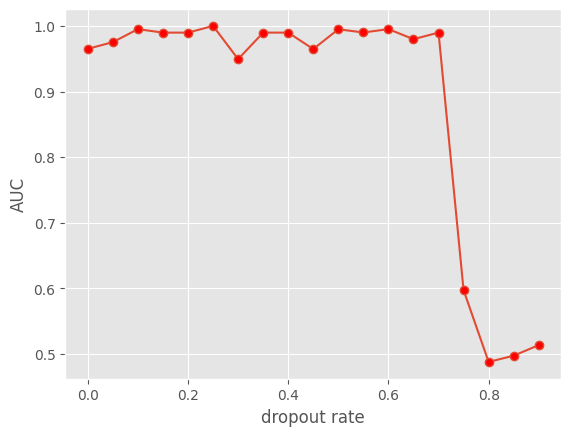

In [286]:
plt.plot(dropouts, scores["aucs"], marker="o", mfc="r")
plt.xlabel("dropout rate")
plt.ylabel("AUC")
plt.savefig("../SimModel_dropout_aucs.png", dpi = 350, facecolor = "white")

## Testing on all the simulated data

In [646]:
def divBy8(x):
    """_summary_
    increases number to next divible number by eight
    Args:
        x (int): input number (max sequence length in dataset)

    Returns:
        int: next number divisible by eight
    """
    
    while x % 8 !=0:
        x += 1
    return x

    

In [647]:
# this code is from dive into deep learning
# this was used as were using lazy loading for the ProtModel

def apply_init(self, inputs, init=None):
    self.forward(*inputs)
    if init is not None:
        self.net.apply(init)

In [648]:


sim_data_paths = dict(zip(sorted(glob.glob("./*seq")), sorted(glob.glob("./*pos"))))

for i, (seq, pos) in enumerate(sim_data_paths.items()):
    name = seq[2:-4].replace("_", "-")
    data = Data(seq, pos)
    input_length = divBy8(len(data))
    # name1 = name + "_noDropout"

    # plotter = VisdomLinePlotter(env_name=name1) 
    # model = SimModel(inputLength=input_length, dropout=0.0, verbose=False).to(DEVICE)
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # trained_model, _, _, _, _ = train_model(
    #     model, data, crit, optimizer, epochs=100, input_length=input_length, batch_size=25
    #     )

    # print("** model with dropout **")   

    # name2 = name + "_dropout0.2"
    # plotter = VisdomLinePlotter(env_name=name2) 
    # model = SimModel(inputLength=input_length, dropout=0.2, verbose=False).to(DEVICE)   
    # trained_model, _, _, _, _ = train_model(
    #     model, data, crit, optimizer, epochs=100, input_length=input_length, batch_size=25
    #     )
        
    name3 = name + "_ProtModel"
    plotter = VisdomLinePlotter(env_name=name3)
    model = ProtModel(dropout = 0.0, verbose=False).to(DEVICE)

    trained_model, _, _, _, _ = train_model(
        model, data, crit, optimizer, epochs=100, input_length=input_length, batch_size=25
        )

Setting up a new session...


epoch: 0	training loss: 0.71	test loss0.70
epoch: 1	training loss: 0.70	test loss0.69
epoch: 2	training loss: 0.72	test loss0.70
epoch: 3	training loss: 0.68	test loss0.69
epoch: 4	training loss: 0.69	test loss0.69
epoch: 5	training loss: 0.72	test loss0.67
epoch: 6	training loss: 0.67	test loss0.69
epoch: 7	training loss: 0.73	test loss0.67
epoch: 8	training loss: 0.70	test loss0.69
epoch: 9	training loss: 0.72	test loss0.69
epoch: 10	training loss: 0.70	test loss0.72


KeyboardInterrupt: 

## ProteinBert 

In [651]:
# Data class for BertTransformer model

class TransformData:
    seed = 13

    def __init__(self, seqPath, posPath, tokenizer):
        self.seq, self.lab = self.read(seqPath, posPath)
        self.train, self.test = self.split(self.seq, self.lab)
        self.length = max(max([len(x) for x in self.train[0]]), max([len(x) for x in self.test[0]]))
        self.tokenizer = tokenizer

    def __repr__(self):
        return self.__class__.__name__ + " instance"

    def __len__(self):
        return self.length

    def read(self, seqPath: str, posPath: str):
        """
        Reads the data from the given sequence and position files.

        Parameters:
        seqPath (str): The path to the sequence file.
        posPath (str): The path to the position file.

        Returns:
        A tuple containing the sequences and labels.
        """

        seq = []
        lab = []
        encode = {}

        with open(seqPath, "r") as f:
            for line in f:
                line = line.strip().split("\t")
                seq.append(line[1])
                lab.append(line[0])

        with open(posPath, "r") as f:
            for line in f:
                line = line.strip()
                encode[line] = [1, 0]

        # TODO: make this compatible with more classes
        lab = [encode.get(x, [0, 1]) for x in lab]
        return (seq, lab)

    def split(self, sequences, labels):
        """
        Splits the data into training and test sets.

        Parameters:
        sequences (list): The sequences.
        labels (list): The labels.

        Returns:
        A tuple containing the training and test sets.
        """

        train_sequences, test_sequences, train_labels, test_labels = train_test_split(
            sequences, labels, test_size=0.2, random_state=TransformData.seed
        )
        return (train_sequences, train_labels), (test_sequences, test_labels)

    def load_data(self, batch_size, num_steps, eval=False):
        """
        Load the data into a data iterator with the specified batch size and number of time steps.

        Parameters:
        batch_size (int): The batch size.
        num_steps (int): The number of time steps.

        Returns:
        A data iterator that returns batches of data with shape (batch_size, num_steps).
        """

        seq, lab = self.test if eval else self.train
        seq = [self.pad_or_trim(x, num_steps) for x in seq]
        seq = [self.add_spaces(x) for x in seq]
        seq = [self.sub_noncanonicals(x) for x in seq]
        seq = self.tokenizer(seq, return_tensors="pt")["input_ids"]
        data_arrays = (seq, torch.tensor(lab))
        data_iter = d2l.load_array(data_arrays, batch_size)
        return data_iter

    def pad_or_trim(self, seq, size):
        """
        Pads or trims the sequence to the specified size.

        Parameters:
        seq (list): The sequence.
        """
        if len(seq) > size:
            return seq[:size]
        return seq + "_" * (size - len(seq))

    def add_spaces(self, seq): 
        """
        Adds spaces between the characters in the sequence.

        Parameters:
        seq (list): The sequence.
        """
        return " ".join(char for char in seq)[:-1]

    def sub_noncanonicals(self, seq):
        """
        Substitutes noncanonical characters with spaces.

        Parameters:
        seq (list): The sequence.
        """
        match = re.compile(r"[UZOB]")
        return match.sub("X", seq)

       

In [652]:
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert")
base_model = BertModel.from_pretrained("Rostlab/prot_bert")

In [653]:
for parameter in base_model.parameters():
    parameter.requires_grad = False 

In [655]:
data = TransformData("len200_500_n5000nr3.seq", "len200_500_n5000nr3.pos", tokenizer = tokenizer)


In [656]:

PRE_TRAINED_MODEL_NAME = 'Rostlab/prot_bert'

class ProteinClassifier(nn.Module):
    def __init__(self, n_classes):
        super(ProteinClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        for parameter in self.bert.parameters():
            parameter.requires_grad = False
          
        self.classifier = nn.Sequential(nn.Dropout(p=0.2),
                                        nn.Linear(self.bert.config.hidden_size, n_classes),
                                        nn.Softmax(dim=1))

    def forward(self, input_ids):
        output = self.bert(
          input_ids=input_ids,
          attention_mask=None
        )
        return self.classifier(output.pooler_output)

In [657]:

def train_model(
    model, data, criterion, optimizer, epochs=10, batch_size=10, input_length=200
):

    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []


    for epoch in range(epochs):

        for X, y in data.load_data(batch_size, input_length):
            X, y = X.to(DEVICE), y.float().to(DEVICE)

            y_hat = model(X)

            loss = criterion(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print("one iteration done")

        plotter.plot("train_loss", "train", "training loss", epoch, loss.item())

        train_losses.append(round(loss.item(), 3))

        acc = (y_hat.argmax(dim=1) == y.argmax(1)).float().mean()
        plotter.plot("train_accuracy", "train", "training accuracy", epoch, acc.item())
        train_accs.append(round(acc.item(), 3))

        with torch.inference_mode():
            for X, y in data.load_data(batch_size, input_length, eval=True):
                X, y = X.to(DEVICE), y.float().to(DEVICE)

                y_hat = model(X)
                loss = criterion(y_hat, y)

        plotter.plot("test_loss", "test", "test loss", epoch, loss.item())
        test_losses.append(round(loss.item(), 3))
        acc = (y_hat.argmax(dim=1) == y.argmax(1)).float().mean()
        plotter.plot("test_accuracy", "test", "test accuracy", epoch, acc.item())
        test_accs.append(round(acc.item(), 3))

        print(
            f"epoch: {epoch}\ttraining loss: {train_losses[-1]}\ttraining accuracy: {train_accs[-1]}\ttest loss: {test_losses[-1]}\ttest accuracy:{test_accs[-1]}"
        )

    return model, train_losses, train_accs, test_losses, test_accs


In [658]:
plotter = VisdomLinePlotter(env_name="BertTokenizerInit")

crit = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model = ProteinClassifier(n_classes=2).to(DEVICE)
bertmodel, trainloss, trainaccs, testloss, testaccs = train_model(model, data, crit, optimizer, epochs = 100, batch_size=25, input_length=512)

Setting up a new session...


one iteration done
one iteration done
one iteration done
one iteration done
one iteration done
one iteration done
one iteration done
one iteration done
one iteration done
one iteration done
one iteration done
one iteration done


KeyboardInterrupt: 

In [ ]:
import glob 

sim_data_paths = dict(zip(sorted(glob.glob("./*seq")), sorted(glob.glob("./*pos"))))

for i, (seq, pos) in enumerate(sim_data_paths.items()):
    name = seq[2:-4].replace("_", "-")
    data = Data(seq, pos)
    input_length = divBy8(len(data))
    # name1 = name + "_noDropout"

    # plotter = VisdomLinePlotter(env_name=name1) 
    # model = SimModel(inputLength=input_length, dropout=0.0, verbose=False).to(DEVICE)
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # trained_model, _, _, _, _ = train_model(
    #     model, data, crit, optimizer, epochs=100, input_length=input_length, batch_size=25
    #     )

    # print("** model with dropout **")   

    # name2 = name + "_dropout0.2"
    # plotter = VisdomLinePlotter(env_name=name2) 
    # model = SimModel(inputLength=input_length, dropout=0.2, verbose=False).to(DEVICE)   
    # trained_model, _, _, _, _ = train_model(
    #     model, data, crit, optimizer, epochs=100, input_length=input_length, batch_size=25
    #     )
        
    name3 = name + "_ProtModel"
    plotter = VisdomLinePlotter(env_name=name3)
    model = ProtModel(dropout = 0.0, verbose=False).to(DEVICE)

    trained_model, _, _, _, _ = train_model(
        model, data, crit, optimizer, epochs=100, input_length=input_length, batch_size=25
        )

## Real Training Data 

In [659]:
class LisData(Data):
    
    def __init__(self, seq_path, pos_path):
        self.class_labels = None
        super().__init__(seq_path, pos_path)
        

    def read(self):
        seqs = {}
        file = self.seqPath
        pos = self.posPath
        with open(file, "r") as f:
            header = None
            for line in f:
                header, seq = line.strip().split("\t")
                seqs[header] = seq
        
        gos = {}
        for file in pos:
            go_term = file.split(".")[0] 
            with open(file, "r") as f:
                gos[go_term] = list(map(str.strip, f.readlines()))

        labels = []

        for seq_key in seqs.keys():
            label_vector = np.zeros(6)
            for i, go_key in enumerate(gos.keys()):
                if seq_key in gos[go_key]:
                    label_vector[i] = 1
            if label_vector.sum() == 0:
                label_vector[-1] = 1
            labels.append(label_vector)

        class_labels = list(gos.keys()) + ["other"]
        
        self.seq = list(seqs.values())
        self.lab = np.array(labels)
        self.class_labels = class_labels    
    
    def remove_negative_data(self, percent_remove= 0.5):
        idx_negative = np.where(self.train[1][:,-1] == 1)[0]
        to_remove = np.random.choice(idx_negative, int(round(len(idx_negative) * percent_remove)), replace=False)
        self.train = [np.delete(self.train[0], to_remove), np.delete(self.train[1], to_remove, axis=0)]

    


In [661]:
data = LisData("expr5Tseq_filtGO_100-1000.lis", pos)
len(data)

IsADirectoryError: [Errno 21] Is a directory: '.'

In [662]:
for x, y in data.load_data(batch_size=25, num_steps=1000):
    print(x.shape)
    break

torch.Size([25, 1001])


In [663]:
%%capture --no-stderr
name = "protModel"
plotter = VisdomLinePlotter(env_name=name)
model = ProtModel(dropout = 0.6, verbose=False, num_classes=6).to(DEVICE)
crit = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

trained_model, _, _, _, _ = train_model(
    model, data, crit, optimizer, epochs=100, input_length=1000, batch_size=25, num_classes=6
    )

Setting up a new session...


TypeError: train_model() got an unexpected keyword argument 'num_classes'

In [428]:
# simple model (SimModel)
name = "simModel_dropout_and_lr0.01"
plotter = VisdomLinePlotter(env_name=name)
model = SimModel(dropout = 0.6, verbose=False, num_classes=6).to(DEVICE)
crit = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

sim_model, _, _, _, _ = train_model(
    model, data, crit, optimizer, epochs=100, input_length=1000, batch_size=25, num_classes=6
    )

Setting up a new session...
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

epoch: 0	training loss: 0.23	test loss0.40


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 1	training loss: 0.33	test loss0.33


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 2	training loss: 0.17	test loss0.33


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 3	training loss: 0.14	test loss0.14


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

KeyboardInterrupt: 

In [419]:
data.remove_negative_data()

In [420]:
# simple model (SimModel) with half of the negative data removed in the trainnig set
name = "simModel-lessNegativeData"
plotter = VisdomLinePlotter(env_name=name)
model = SimModel(dropout = 0.6, verbose=False, num_classes=6).to(DEVICE)
crit = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

sim_model, _, _, _, _ = train_model(
    model, data, crit, optimizer, epochs=100, input_length=1000, batch_size=25, num_classes=6
    )

Setting up a new session...
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result

epoch: 0	training loss: 0.25	test loss0.20


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 1	training loss: 0.57	test loss0.24


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 2	training loss: 0.33	test loss0.28


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 3	training loss: 0.34	test loss0.37


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 4	training loss: 0.28	test loss0.26


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 5	training loss: 0.42	test loss0.32


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 6	training loss: 0.28	test loss0.23


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 7	training loss: 0.50	test loss0.23


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 8	training loss: 0.36	test loss0.26


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 9	training loss: 0.45	test loss0.50


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 10	training loss: 0.41	test loss0.27


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 11	training loss: 0.34	test loss0.33


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 12	training loss: 0.25	test loss0.29


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 13	training loss: 0.23	test loss0.21


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 14	training loss: 0.33	test loss0.20


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 15	training loss: 0.34	test loss0.20


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 16	training loss: 0.22	test loss0.12


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 17	training loss: 0.43	test loss0.47


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 18	training loss: 0.15	test loss0.48


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 19	training loss: 0.29	test loss0.18


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 20	training loss: 0.28	test loss0.20


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 21	training loss: 0.39	test loss0.18


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 22	training loss: 0.35	test loss0.11


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 23	training loss: 0.41	test loss0.16


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 24	training loss: 0.39	test loss0.46


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 25	training loss: 0.20	test loss0.24


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 26	training loss: 0.20	test loss0.18


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 27	training loss: 0.33	test loss0.90


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 28	training loss: 0.21	test loss0.14


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 29	training loss: 0.29	test loss0.48


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 30	training loss: 0.19	test loss1.02


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 31	training loss: 0.32	test loss0.24


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 32	training loss: 0.19	test loss0.51


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 33	training loss: 0.34	test loss0.22


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 34	training loss: 0.17	test loss0.33


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 35	training loss: 0.18	test loss0.50


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 36	training loss: 0.19	test loss0.59


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 37	training loss: 0.14	test loss0.09


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 38	training loss: 0.13	test loss0.34


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 39	training loss: 0.14	test loss0.41


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 40	training loss: 0.25	test loss0.25


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 41	training loss: 0.23	test loss0.32


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

epoch: 42	training loss: 0.53	test loss0.39


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 43	training loss: 0.26	test loss0.19


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 44	training loss: 0.11	test loss0.35


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 45	training loss: 0.14	test loss0.37


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 46	training loss: 0.46	test loss1.00


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 47	training loss: 0.19	test loss0.14


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 48	training loss: 0.19	test loss0.22


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 49	training loss: 0.13	test loss0.20


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is"

epoch: 50	training loss: 0.50	test loss0.55


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 51	training loss: 0.29	test loss0.46


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 52	training loss: 0.16	test loss0.26


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 53	training loss: 0.23	test loss0.33


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 54	training loss: 0.34	test loss0.80


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 55	training loss: 0.19	test loss0.23


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 56	training loss: 0.11	test loss0.25


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 57	training loss: 0.09	test loss0.14


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 58	training loss: 0.25	test loss1.13


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

epoch: 59	training loss: 0.49	test loss0.45


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 60	training loss: 0.07	test loss0.52


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 61	training loss: 0.18	test loss0.19


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 62	training loss: 0.29	test loss0.08


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 63	training loss: 0.23	test loss0.18


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 64	training loss: 0.16	test loss0.62


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is"

epoch: 65	training loss: 0.15	test loss1.40


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 66	training loss: 0.23	test loss0.18


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 67	training loss: 0.20	test loss0.20


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 68	training loss: 0.12	test loss0.35


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 69	training loss: 0.17	test loss1.01


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 70	training loss: 0.18	test loss0.63


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

epoch: 71	training loss: 0.69	test loss0.13


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 72	training loss: 0.07	test loss3.14


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 73	training loss: 0.17	test loss0.30


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 74	training loss: 0.25	test loss0.29


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 75	training loss: 0.22	test loss0.14


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 76	training loss: 0.21	test loss0.78


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 77	training loss: 0.10	test loss0.51


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 78	training loss: 0.11	test loss0.23


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 79	training loss: 0.37	test loss0.96


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 80	training loss: 0.28	test loss0.25


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

epoch: 81	training loss: 0.29	test loss0.59


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 82	training loss: 0.24	test loss0.61


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 83	training loss: 0.24	test loss0.65


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 84	training loss: 0.14	test loss1.41


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 85	training loss: 0.12	test loss0.23


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 86	training loss: 0.31	test loss0.72


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 87	training loss: 0.29	test loss0.18


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 88	training loss: 0.17	test loss0.44


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 89	training loss: 0.19	test loss0.49


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 90	training loss: 0.16	test loss0.25


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 91	training loss: 0.20	test loss0.22


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 92	training loss: 0.35	test loss0.62


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 93	training loss: 0.22	test loss2.33


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 94	training loss: 0.29	test loss1.04


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 95	training loss: 0.05	test loss0.64


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 96	training loss: 0.03	test loss0.14


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 97	training loss: 0.31	test loss0.19


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 98	training loss: 0.19	test loss0.10


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

epoch: 99	training loss: 0.12	test loss0.50


/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

In [406]:
def intersection(list1, list2):
    a = list1
    for b in list2.values():
        length = len(set(a) & set(b))
        print(length)


## Validation Data 

In [610]:
class ValidationData(Data):

    def __init__(self, seq_path, pos_path):
        self.class_labels = None
        super().__init__(seq_path, pos_path)
            

    def read(self):
        seqs = {}
        with open(self.seqPath) as f:
            for record in SeqIO.parse(f, "fasta"):
                seqs[record.id] = str(record.seq)
        
        self.seq = list(seqs.values())
        self.ids = list(seqs.keys())

    def init_data(self):
        self.read()
        self.length = max([len(seq) for seq in self.seq])


    def load_data(self, batch_size, num_steps):
        mapaa2num = {aa: i for (i, aa) in enumerate(list("ACDEFGHIKLMNPQRSTVWY"))}
        seq = self.seq
        seq = self.tokenize(seq, mapaa2num)
        seq_array = self.build_seq_array(seq, num_steps)
        one_hot_array = nn.functional.one_hot(seq_array, -1).float()
        data_iter = DataLoader(one_hot_array, batch_size=batch_size, shuffle=False)
        return data_iter
        

In [611]:
valdata =ValidationData("test_set_filt.f", None)

In [620]:
predictions = None

with torch.inference_mode():
    for i, X in enumerate(valdata.load_data(batch_size=25, num_steps=1000)):
        X = torch.permute(X, (0, 2, 1)).to(DEVICE)
        pred = (trained_model(X).cpu().detach().numpy() > 0.5).astype(int)
        if predictions is None:
            predictions = pred
        else:
            predictions = np.concatenate((predictions, pred))
        




In [621]:
len(valdata.seq)

14765

In [623]:
pd.DataFrame(predictions, columns=data.class_labels, index=valdata.ids).to_csv("predictions.csv")